# Some considerations

- Neural Inpainting : on actual license plates, its probable that due to noise/perspective etc. , when we extract single characters, parts of the characters will be missing. We could try to have a neural inpainting type of model, where we hide parts of the characters in the synthetic dataset and train the model to reconstruct these

- from : https://www.linkedin.com/advice/0/how-can-you-use-variational-autoencoders-xxipf#:~:text=Variational%20autoencoders%20(VAEs)%20can%20restore,latent%20space%2C%20capturing%20essential%20features.

I have utilized VAEs in my projects, and the way they reconstruct the image is incredible. AEs for image restoration involve training two encoders: one for real and synthetically degraded images, and another for clean images. The encoders compress images into a shared latent space and a separate clean space, respectively. The network then learns a mapping between these spaces using synthetic image pairs, allowing it to "translate" the latent representation of a degraded image towards the clean space. Finally, a decoder utilizes this translated representation to reconstruct a restored image, aiming to be closer to the original.

vAE image reconstruction : 

https://arxiv.org/pdf/2305.02541
https://github.com/mdhabibi/DeepLearning-VAE



- In this code, I will consider a variational AE that should reconstruct the actual characters based on corrupted/noisy/partial characters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import os
from pathlib import Path
import shutil
import matplotlib.pyplot as plt

# FIRST TRIAL :

- only one vAE, that takes both clean & noisy images as input 

In [2]:
class LicensePlateVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(LicensePlateVAE, self).__init__()
        
        # Encoder for both clean and noisy images
        self.encoder = nn.Sequential(
            # Input: 1x28x28
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Flatten(), # 64 * 7 * 7

        )
        
        # Latent space ; both have their own respective linear layer 
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_var = nn.Linear(64 * 7 * 7, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)), # unflatten into 64x7x7 tensor
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output should be between 0 and 1 for binary images (i.e the pixel values)
            # TODO : check if actually our input 28x28 are between 0,1 or -1,1, else sigmoid should become tanh
        )
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        # Create std and eps of a Gaussian distribution
        std = torch.exp(0.5 * log_var)
        # randn_like creates a tensor with the same shape as std (or mu, they have the same shape), with values sampled from a standard normal distribution
        eps = torch.randn_like(std) 
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_input(z)
        return self.decoder(x)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [3]:
def vae_loss_function_multi_target(recon_x, clean_targets, mu, log_var, beta=1.0):
    """
    VAE loss function that handles multiple clean targets for each noisy input
    
    Args:
        recon_x: Reconstructed image (B x 1 x 28 x 28)
        clean_targets: Multiple clean targets for each input (B x N x 1 x 28 x 28)
        where N is the number of clean targets per noisy input
        mu, log_var: Latent distributions
    """
    # Calculate BCE for each clean target
    bce_losses = []
    for i in range(clean_targets.size(1)):  # Iterate over N targets
        target = clean_targets[:, i]
        # Binary cross entropy useful here, as we have binary (black/white) images and
        # In the case of images, each pixel value is treated as a probability between 0 (black) and 1 (white)
        # thus, we measure the likelihood of the reconstructed image given the target image
        bce = F.binary_cross_entropy(recon_x, target, reduction='sum')
        bce_losses.append(bce)
    
    # Take minimum BCE across all targets (meaning we choose the target that is closest to the reconstructed image, i.e. the best fit)
    # We don't care for the vAE to generate a certain clean picture : We just want it to generate a clean picture, such that we can
    # see which character it is !
    BCE = torch.min(torch.stack(bce_losses))
    
    # KL divergence remains the same
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Possible optimization for KLD :
    #https://discuss.pytorch.org/t/correct-implementation-of-vae-loss/146750
    # KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),dim=1),dim=0)
    
    return BCE + beta * KLD

In [4]:
def train_vae_multi_target(model, train_loader, optimizer, device, epoch, beta=1.0):
    model.train()
    train_loss = 0
    
    for batch_idx, (noisy, clean_targets) in enumerate(train_loader):
        # noisy: [B x 1 x 28 x 28]
        # clean_targets: [B x N x 1 x 28 x 28] where N is num_clean_targets
        noisy = noisy.to(device)
        clean_targets = clean_targets.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass with noisy input
        recon_batch, mu, log_var = model(noisy)
        
        # Calculate loss using multiple clean targets
        loss = vae_loss_function_multi_target(recon_batch, clean_targets, mu, log_var, beta)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(noisy)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(noisy):.6f}')
    
    return train_loss / len(train_loader.dataset)

In [4]:
def train_vae_multi_target(model, train_loader, val_loader, optimizer, device, num_epochs, beta=1.0, patience=5):
    """
    Train VAE with validation and early stopping
    
    Args:
        model: VAE model
        train_loader: Training data loader
        val_loader: Validation data loader
        optimizer: Optimizer
        device: Device to run on
        num_epochs: Maximum number of epochs
        beta: Weight of KL divergence term
        patience: Number of epochs to wait for improvement before early stopping
    """
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        
        for batch_idx, (noisy, clean_targets) in enumerate(train_loader):
            noisy = noisy.to(device)
            clean_targets = clean_targets.to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(noisy)
            loss = vae_loss_function_multi_target(recon_batch, clean_targets, mu, log_var, beta)
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(noisy)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(noisy):.6f}')
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for noisy, clean_targets in val_loader:
                noisy = noisy.to(device)
                clean_targets = clean_targets.to(device)
                
                recon_batch, mu, log_var = model(noisy)
                loss = vae_loss_function_multi_target(recon_batch, clean_targets, mu, log_var, beta)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # Print epoch results
        print(f'====> Epoch: {epoch} Average train loss: {avg_train_loss:.4f}')
        print(f'====> Epoch: {epoch} Average validation loss: {avg_val_loss:.4f}')
        
        # Check if this is the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'beta': beta
            }, '/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/vAE_model/license_plate_vae.pth')
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses



In [5]:
# Function to visualize training progress
def plot_training_progress(train_losses, val_losses):
    """
    Plot training and validation losses
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()



In [7]:
# Function to visualize reconstructions
def visualize_reconstructions(model, val_loader, device, num_examples=5):
    """
    Visualize some example reconstructions
    """
    model.eval()
    with torch.no_grad():
        for noisy, clean_targets in val_loader:
            noisy = noisy.to(device)
            clean_targets = clean_targets.to(device)
            
            recon_batch, _, _ = model(noisy)
            
            # Plot results
            fig, axes = plt.subplots(3, num_examples, figsize=(15, 6))
            for i in range(num_examples):
                # Plot noisy input
                axes[0, i].imshow(noisy[i].cpu().squeeze(), cmap='gray')
                axes[0, i].axis('off')
                if i == 0:
                    axes[0, i].set_title('Noisy Input')
                
                # Plot reconstruction
                axes[1, i].imshow(recon_batch[i].cpu().squeeze(), cmap='gray')
                axes[1, i].axis('off')
                if i == 0:
                    axes[1, i].set_title('Reconstruction')
                
                # Plot one clean target
                axes[2, i].imshow(clean_targets[i, 0].cpu().squeeze(), cmap='gray')
                axes[2, i].axis('off')
                if i == 0:
                    axes[2, i].set_title('Clean Target')
            
            plt.tight_layout()
            plt.show()
            break

In [8]:
class LicensePlateDatasetMultiTarget(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_dir = noisy_dir
        self.clean_base_dir = clean_dir
        self.transform = transform
        self.clean_path = Path(clean_dir)
        self.noisy_path = Path(noisy_dir)
        
        # Get all noisy image files

        self.noisy_files = []
        for folder in self.noisy_path.iterdir():
            if folder.is_dir():
                self.noisy_files.extend(list(folder.glob('*.png')))

    
    
    def __len__(self):
        return len(self.noisy_files)
    
    def __getitem__(self, idx):
        noisy_name = self.noisy_files[idx]
        char_class = noisy_name.name.split('_')[0]  # filenames have format like "F_1.png"
        
        # Load noisy image
        noisy_img = Image.open(self.noisy_path / char_class / noisy_name)
        
        clean_images = []
        # Find the corresponding clean images to the current noisy image
        curr_clean_path = self.clean_path / char_class
     

        for img in list(curr_clean_path.glob('*.png')):
            clean_img = Image.open(img)
            if self.transform:
                clean_img = self.transform(clean_img)
            clean_images.append(clean_img)


        if self.transform:
            noisy_img = self.transform(noisy_img)
            
        # Stack clean images into a single tensor
        clean_tensor = torch.stack(clean_images)
        
        return noisy_img, clean_tensor

In [9]:
def create_train_val_test_folders(clean_dir, noisy_dir):
    """Function to create train, validation, and test folders
       The idea is to take 80%/10%/10% of each characters folder for train,validation and test respectively"""
    
    # First check if folders exist and delete them
    # TODO : maybe remove later, for now just so we don't keep different images in these folders when we try diff. image augmentation methods etc. 
    for folder in ['train', 'val', 'test']:
        if os.path.exists(os.path.join(clean_dir, folder)):
            shutil.rmtree(os.path.join(clean_dir, folder))
        if os.path.exists(os.path.join(noisy_dir, folder)):
            shutil.rmtree(os.path.join(noisy_dir, folder))

    # Create folders (if not existent yet)
    for folder in ['train', 'val', 'test']:
        os.makedirs(os.path.join(clean_dir, folder), exist_ok=True)
        os.makedirs(os.path.join(noisy_dir, folder), exist_ok=True)


    characters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    # and also create folders for each of the possible characters
    for char in characters:
        os.makedirs(os.path.join(clean_dir, 'train', char), exist_ok=True)
        os.makedirs(os.path.join(clean_dir, 'val', char), exist_ok=True)
        os.makedirs(os.path.join(clean_dir, 'test', char), exist_ok=True)
        os.makedirs(os.path.join(noisy_dir, 'train', char), exist_ok=True)
        os.makedirs(os.path.join(noisy_dir, 'val', char), exist_ok=True)
        os.makedirs(os.path.join(noisy_dir, 'test', char), exist_ok=True)

    train_clean = {}
    val_clean = {}
    test_clean = {}
    train_noisy = {}
    val_noisy = {}
    test_noisy = {}
    clean_path = Path(clean_dir)
    noisy_path = Path(noisy_dir)
    # Iterate through all clean folders (i.e. each character)
    for folder in clean_path.iterdir():
        if folder.is_dir(): 
            files_train = (list(folder.glob('*.png')))[:80]
            files_val = (list(folder.glob('*.png')))[80:90]
            files_test = (list(folder.glob('*.png')))[90:100]
            # Store in dictionary for now 
            train_clean[folder.name] = files_train
            val_clean[folder.name] = files_val
            test_clean[folder.name] = files_test
    
    # For noisy images
    for folder in noisy_path.iterdir():
        if folder.is_dir(): 
            files_train = (list(folder.glob('*.png')))[:80]
            files_val = (list(folder.glob('*.png')))[80:90]
            files_test = (list(folder.glob('*.png')))[90:100]
            # Store in dictionary for now
            train_noisy[folder.name] = files_train
            val_noisy[folder.name] = files_val
            test_noisy[folder.name] = files_test

            


        # Copy files to respective folders (clean)
        for char, files in train_clean.items():
            for file in files:
                shutil.copy2(file, clean_path / 'train' / char / file.name)
        for char, files in val_clean.items():
            for file in files:
                shutil.copy2(file, clean_path / 'val' / char / file.name)
        for char, files in test_clean.items():
            for file in files:
                shutil.copy2(file, clean_path / 'test' / char / file.name)


        # Copy files to respective folders (noisy)
        for char, files in train_noisy.items():
            for file in files:
                shutil.copy2(file, noisy_path / 'train' / char / file.name)
        for char, files in val_noisy.items():
            for file in files:
                shutil.copy2(file, noisy_path / 'val' / char / file.name)
        for char, files in test_noisy.items():
            for file in files:
                shutil.copy2(file, noisy_path / 'test' / char / file.name)


In [ ]:
def evaluate_test_set(model, test_loader, device):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for noisy, clean_targets in test_loader:
            noisy = noisy.to(device)
            clean_targets = clean_targets.to(device)
            
            recon_batch, mu, log_var = model(noisy)
            loss = vae_loss_function_multi_target(recon_batch, clean_targets, mu, log_var)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f'====> Test set loss: {avg_test_loss:.4f}')

In [10]:
def main():
    # Hyperparameters
    latent_dim = 32
    batch_size = 64
    learning_rate = 1e-3
  
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Data transforms
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Create datasets and dataloaders
    dataset_train = LicensePlateDatasetMultiTarget(
        clean_dir='/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/data/synthetic/german_font/clean/train',
        noisy_dir='/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/data/synthetic/german_font/noisy/train',
        transform=transform,
    )

    dataset_val = LicensePlateDatasetMultiTarget(
        clean_dir='/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/data/synthetic/german_font/clean/val',
        noisy_dir='/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/data/synthetic/german_font/noisy/val',
        transform=transform,
    )

    dataset_test = LicensePlateDatasetMultiTarget(
        clean_dir='/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/data/synthetic/german_font/clean/test',
        noisy_dir='/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/data/synthetic/german_font/noisy/test',
        transform=transform,
    )


    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


    # Get some element from the Training DataLoader (for testing)
   # train_loader_iter = iter(train_loader)
   # noisy, clean_targets = next(train_loader_iter)

   # print(noisy.shape)
   # print(clean_targets.shape)
    
    # Initialize model
    model = LicensePlateVAE(latent_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    model, train_losses, val_losses = train_vae_multi_target(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=10,
        beta=1.0, # for KL divergence 
        patience=5
    )

    # Plot training progress
    plot_training_progress(train_losses, val_losses)
    
    # Show some reconstructed examples from the validation set
    visualize_reconstructions(model, val_loader, device, num_examples=5)


    # Evaluate on the test set
    evaluate_test_set(model, test_loader, device)

    # Visualize some reconstructions from test set
    visualize_reconstructions(model, test_loader, device, num_examples=5)



Train Epoch: 0 [0/2880 (0%)]	Loss: 535.721863
====> Epoch: 0 Average train loss: 282.5651
====> Epoch: 0 Average validation loss: 178.0130
Train Epoch: 1 [0/2880 (0%)]	Loss: 177.599960
====> Epoch: 1 Average train loss: 173.2782
====> Epoch: 1 Average validation loss: 170.9477
Train Epoch: 2 [0/2880 (0%)]	Loss: 168.480637
====> Epoch: 2 Average train loss: 168.8955
====> Epoch: 2 Average validation loss: 168.6465
Train Epoch: 3 [0/2880 (0%)]	Loss: 166.217499
====> Epoch: 3 Average train loss: 167.3623
====> Epoch: 3 Average validation loss: 165.7237
Train Epoch: 4 [0/2880 (0%)]	Loss: 165.892487
====> Epoch: 4 Average train loss: 165.5245
====> Epoch: 4 Average validation loss: 164.0307
Train Epoch: 5 [0/2880 (0%)]	Loss: 164.060944
====> Epoch: 5 Average train loss: 163.4180
====> Epoch: 5 Average validation loss: 161.0659
Train Epoch: 6 [0/2880 (0%)]	Loss: 163.641174
====> Epoch: 6 Average train loss: 161.4026
====> Epoch: 6 Average validation loss: 160.3553
Train Epoch: 7 [0/2880 (0%)

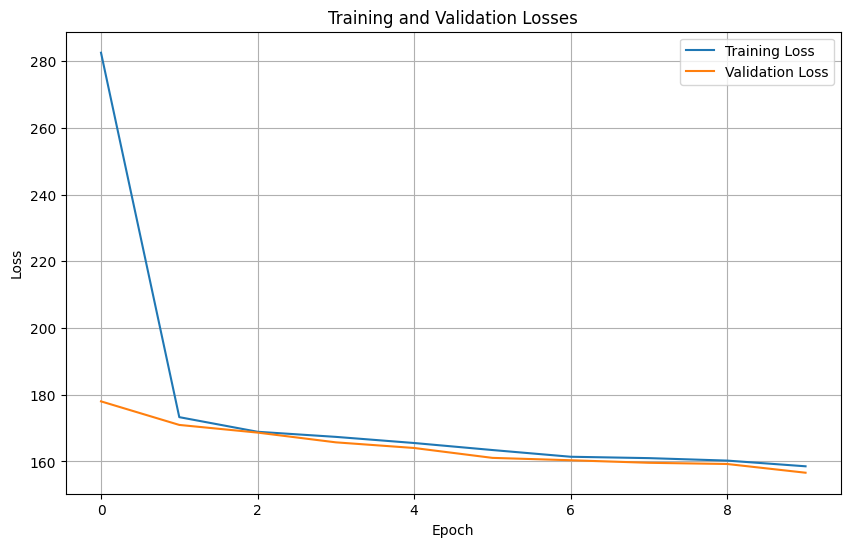

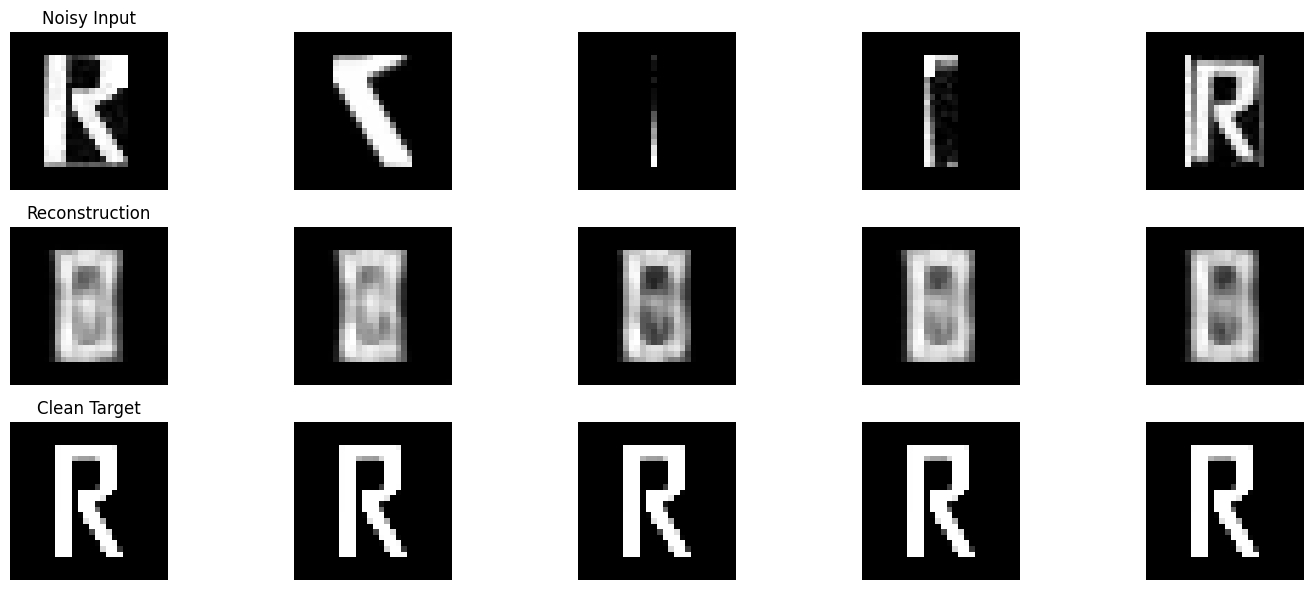

In [11]:
if __name__ == '__main__':
    main()

In [18]:
create_train_val_test_folders('/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/data/synthetic/german_font/clean', '/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/data/synthetic/german_font/noisy')